# Project overview 
Fine-tune a ResNet18 to classify cats and dogs
Steps: 
1. Split data
2. Build loaders
3. Train with early stopping
4. Export best model
5. Launch a Gradio demo

In [1]:
# Import Libraries 
import os
import shutil
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split  
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import gradio as gr
from torchvision import models

# Data preparation
Input is a single folder, files are named like catXXXX.jpeg and dogXXXX.jpeg  
We split into train and validation once and reuse the split on future runs

In [3]:
original_dir = '/Users/rimona/Desktop/dataset/catdog/train'  
output_dir   = 'output_data'                              
train_ratio  = 0.8                                        

# Only run if output_data doesn't already exist 
if not os.path.exists(output_dir):

    # Make train/val subfolders for cats and dogs 
    for split in ['train', 'val']:
        for cls in ['cats', 'dogs']:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    # Separate cat and dog filenames 
    all_images = os.listdir(original_dir)
    cat_images = [f for f in all_images if f.startswith('cat')]
    dog_images = [f for f in all_images if f.startswith('dog')]

    # Shuffle so split is random but reproducible 
    random.seed(42)
    random.shuffle(cat_images)
    random.shuffle(dog_images)

    # Function: split into train/val and copy to folders
    def split_and_copy(files, cls, ratio=train_ratio):
        n_train = int(len(files) * ratio)  # number for training set
        train_files = files[:n_train]
        val_files   = files[n_train:]

        for f in train_files:
            shutil.copy(os.path.join(original_dir, f),
                        os.path.join(output_dir, 'train', cls))
        for f in val_files:
            shutil.copy(os.path.join(original_dir, f),
                        os.path.join(output_dir, 'val', cls))

    # Do the split for both cats and dogs 
    split_and_copy(cat_images, 'cats')
    split_and_copy(dog_images, 'dogs')

    print('Dataset split complete')

else:
    print('Output_data already exists. Skipping split.')


Output_data already exists. Skipping split.


In [5]:
# Counts
def count(p): return len(os.listdir(p))
print("Counts:",
      "train cats", count('output_data/train/cats'),
      "train dogs", count('output_data/train/dogs'),
      "val cats",   count('output_data/val/cats'),
      "val dogs",   count('output_data/val/dogs'))


Counts: train cats 10000 train dogs 10000 val cats 2500 val dogs 2500


In [7]:
device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if hasattr(torch.backends, "mps") and torch.backends.mps.is_available()
    else torch.device("cpu")
)
print("Device:", device)

Device: mps


# Training setup
Train transform adds light augments, val is resize only  
Loaders use ImageFolder from `output_data/train` and `output_data/val` with batch size 32; train shuffles 
ResNet18 pretrained, backbone frozen, final layer set to 2 classes, moved to device
Loss is CrossEntropy, optimizer is Adam on the head (lr 1e-3, weight decay 1e-4) 
Early stopping: 10 epochs max, track best validation loss with patience 3

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


train_data = datasets.ImageFolder("output_data/train", transform=train_transform)
val_data   = datasets.ImageFolder("output_data/val", transform=val_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=32)

In [13]:
# Load pretrained ResNet18

weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier for 2 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=1e-4)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)

patience = 3
bad_epochs = 0
epochs = 10
best_val_loss = float('inf')


# Training and validation
Per epoch:
1. Train on mini-batches and update only the head
2. Evaluate on validation without updating weights
3. Save the best model by validation loss


In [21]:
# Training
for epoch in range(1, epochs + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / max(1, len(train_loader))
    train_acc  = correct / max(1, total)
    
# Validation 
    model.eval()
    val_running, v_correct, v_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running += loss.item()
            _, preds = outputs.max(1)
            v_correct += (preds == labels).sum().item()
            v_total += labels.size(0)

    val_loss = val_running / max(1, len(val_loader))
    val_acc  = v_correct / max(1, v_total)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping 
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        bad_epochs = 0
        torch.save(model.state_dict(), 'best_model_dogcat.pt')
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping at epoch {epoch} (best val loss {best_val_loss:.4f})")
            break

print("Done. Best model saved to best_model_dogcat.pt")


Epoch 01/10 | Train Loss: 0.1020 | Train Acc: 0.9596 | Val Loss: 0.0599 | Val Acc: 0.9776
Epoch 02/10 | Train Loss: 0.0961 | Train Acc: 0.9639 | Val Loss: 0.0583 | Val Acc: 0.9778
Epoch 03/10 | Train Loss: 0.0949 | Train Acc: 0.9629 | Val Loss: 0.0636 | Val Acc: 0.9752
Epoch 04/10 | Train Loss: 0.0890 | Train Acc: 0.9660 | Val Loss: 0.0732 | Val Acc: 0.9704
Epoch 05/10 | Train Loss: 0.0919 | Train Acc: 0.9625 | Val Loss: 0.0672 | Val Acc: 0.9732
Early stopping at epoch 5 (best val loss 0.0583)
Done. Best model saved to best_model_dogcat.pt


# Metrics and confusion matrix 
Confusion matrix helps see which class is misclassified more often
The model predicts “dog” more often even though classes are balanced.

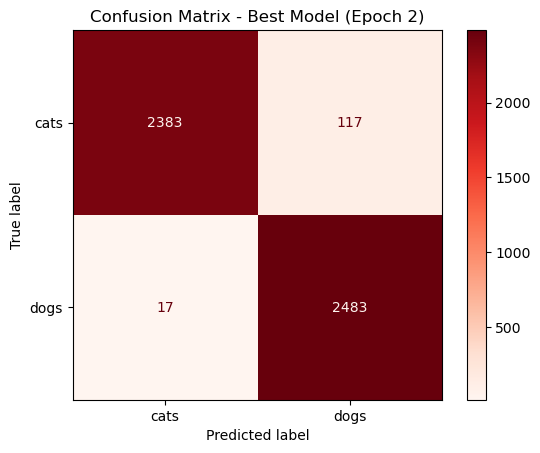

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 1. Make predictions on the validation set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# 2. Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# 3. Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_data.classes)
disp.plot(cmap='Reds')
plt.title("Confusion Matrix - Best Model (Epoch 2)")
plt.show()
